In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import rel_entr

### Load Data

In [68]:
loaded = np.load('./data/stag_hunt_S_5M.npz')
name = 'Stag Hunt Small'
rewards = loaded['rewards']
checkpoints = loaded['checkpoints']
row_rewards = rewards[:,:,0]
col_rewards = rewards[:,:,1]
row_rewards

array([[45.90238095, 59.0984127 , 45.87777778, 52.85746032, 53.97619048,
        58.47460317, 58.75873016, 47.8962963 , 48.84179894, 41.59722222,
        44.27880342, 57.1531746 , 46.51904762, 57.88677249, 53.12984127,
        52.7493266 , 51.12904762, 54.01904762, 61.35873016, 51.88571429,
        57.71555556, 40.32207792, 61.44444444, 56.41904762, 56.17777778,
        49.46428571, 61.00444444, 48.43809524, 44.25185185, 62.21111111,
        54.39312169, 57.14285714, 58.11904762, 53.84      , 54.17222222,
        50.77037037, 55.6984127 , 54.48571429, 57.65079365, 59.69925926,
        54.28253968, 51.97777778, 67.58333333, 49.47015873, 48.10529101,
        47.7631746 , 52.34074074, 56.8447619 , 53.33518519, 56.81904762],
       [45.24761905, 53.21111111, 57.02871573, 53.3952381 , 43.14920635,
        50.6       , 63.43703704, 49.0017316 , 53.88015873, 56.06031746,
        65.08888889, 50.85      , 58.8       , 69.85238095, 58.95238095,
        47.2031746 , 45.84571429, 60.03809524, 55.

### KL Divergence

In [69]:
# start = np.min(row_rewards)
# end = np.max(row_rewards)
start = 0
end = 150
num_bins = 50
# marginal distribution
total_rewards = row_rewards.flatten()
marginal_hist, marginal_bin_edges = np.histogram(total_rewards, bins=num_bins, range=(start, end))
marginal_distribution = marginal_hist / sum(marginal_hist)
# KL divergence
KL_divergence = np.zeros(len(row_rewards))
for i in range(len(row_rewards)):
    hist, bin_edges = np.histogram(row_rewards[i], bins=num_bins, range=(start, end))
    distribution = hist / sum(hist)
    KL_divergence[i] = sum(rel_entr(distribution,marginal_distribution))
# index
index = sum(KL_divergence)/len(KL_divergence)
print(index)

0.7377551295441197


### Turn to DataFrame

In [70]:
# convert to dataframe for plotting
checkpoint_str = ["checkpoint "+str(x) for x in checkpoints]
# reshape the 2D Numpy array to 1D array
flattened_ego_rewards = row_rewards.flatten()
flattened_opp_rewards = col_rewards.flatten()
# Create column names for the DataFrame
column_names = ['row reward', 'col reward', 'checkpoint']
# Create an array with repeated row numbers
checkpoint_names = np.repeat(checkpoint_str, len(row_rewards[0]))
# Create the DataFrame
df = pd.DataFrame({'row reward': flattened_ego_rewards, 'col reward': flattened_opp_rewards, 'checkpoint': checkpoint_names}, columns=column_names)
df

,row reward,col reward,checkpoint
0,45.902381,47.328571,checkpoint 20
1,59.098413,59.784127,checkpoint 20
2,45.877778,44.777778,checkpoint 20
3,52.857460,58.057460,checkpoint 20
4,53.976190,52.479365,checkpoint 20
...,...,...,...
545,83.372222,84.322222,checkpoint 2600
546,80.544444,80.411111,checkpoint 2600
547,79.011111,79.311111,checkpoint 2600
548,68.107937,70.998413,checkpoint 2600


### Ridge Plot

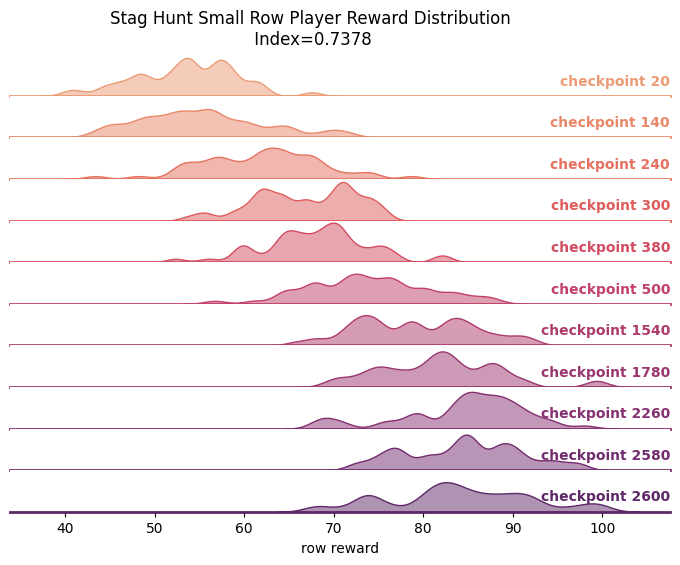

In [71]:
g = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='flare')
# h = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='crest')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="row reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map_dataframe(sns.kdeplot, x="opp_reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1, .2, label, fontweight="bold", color=color,
            ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "row reward")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=f'{name} Row Player Reward Distribution\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join('./plots/', name+' row reward distribution.pdf'), bbox_inches='tight')

### Comparison DataFrame

In [72]:
new_df = pd.DataFrame({'reward': df['col reward'].tolist()+df['row reward'].tolist(),
                       'label': ['col']*len(df['col reward'])+['row']*len(df['row reward']),
                       'checkpoint': df['checkpoint'].tolist()*2},
                      columns=['reward','label','checkpoint'])
new_df

,reward,label,checkpoint
0,47.328571,col,checkpoint 20
1,59.784127,col,checkpoint 20
2,44.777778,col,checkpoint 20
3,58.057460,col,checkpoint 20
4,52.479365,col,checkpoint 20
...,...,...,...
1095,83.372222,row,checkpoint 2600
1096,80.544444,row,checkpoint 2600
1097,79.011111,row,checkpoint 2600
1098,68.107937,row,checkpoint 2600


### Comparison Ridge Plot

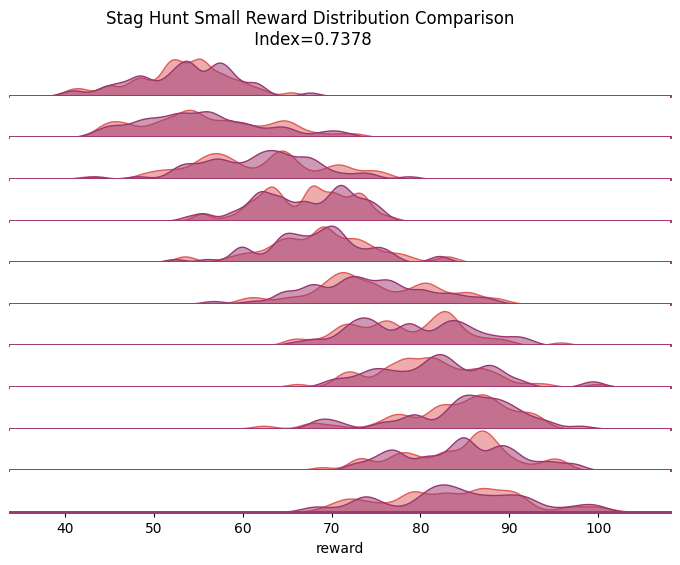

In [73]:
g = sns.FacetGrid(new_df, row="checkpoint", hue="label", aspect=15, height=.5, palette='flare')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map(sns.kdeplot, "reward", clip_on=False, color="w", lw=2, bw_adjust=.3)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # ax.text(1, .2, label, fontweight="bold", color=color,
    #         ha="right", va="bottom", transform=ax.transAxes)
# def annotate(data, color, **kws):
#     n = data['checkpoint']
#     ax = plt.gca()
#     ax.text(1, 0.2, f'{n}', fontweight="bold", color=color, ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "reward")
# g.map_dataframe(annotate)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=f'{name} Reward Distribution Comparison\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join('./plots/', name+' distribution comparison.pdf'), bbox_inches='tight')